# Network Prediction
Please run the ```Convallaria-Training.ipynb``` before.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import torch
from tifffile import imread
import sys
sys.path.append('../../../')
from unet.model import UNet
from deconoising.utils import PSNR
from deconoising import utils
from deconoising import prediction
from deconoising import pn2v_utils as utils
from deconoising import pn2v_training as training
#import pn2v.training

from PIL import Image
import cv2 as cv

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

In [2]:
# We need the training data in order to calulate 'mean' and 'std' for normalization
#path='./data/Convallaria_diaphragm/'
path='./Mouse actin/diaphragm.tif'
#path='./images/noisy_image/'
# Load the test data

#Converting 2D image to 3D
# grayscale_img = Image.open(path+'A172_Phase_A7_1_00d00h00m_1.tif').convert('L')
# grayscale_array = np.array(grayscale_img)
# rgb_array = np.stack((grayscale_array,)*3,axis=-1)
# rgb_image = Image.fromarray(rgb_array,'RGB')
# rgb_image.save(path+'RGB_img1.tif')
# dataTest=imread(path+'RGB_img1.tif')[:,:512,:512]

#dataTest=imread(path+'bw.tiff')[:512,:512]
#dataTest=imread(path+'A172_Phase_A7_1_00d00h00m_1.tif')[:512,:512]

#dataTest=imread(path+'20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif')[:,:512,:512]
#dataTest=imread(path+'20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif')[20,:512,:512]
dataTest=imread(path)[:,:512,:512]
# We are loading only a sub image to spped up computation
dataTest = dataTest - 520.0 # subtract a mean value for the background
# We estimate the ground truth by averaging.
dataTestGT = np.mean(dataTest[:,...],axis=0)[np.newaxis,...]

(100, 512, 512)
-224.0
5058.0


(array([6.858000e+03, 8.737690e+05, 2.494765e+06, 1.922686e+06,
        1.335942e+06, 1.080337e+06, 9.778910e+05, 8.968490e+05,
        8.227800e+05, 7.868250e+05, 7.603370e+05, 7.524440e+05,
        7.803870e+05, 8.146530e+05, 8.792210e+05, 9.366090e+05,
        9.803720e+05, 1.030921e+06, 1.051306e+06, 1.035564e+06,
        1.012071e+06, 9.441210e+05, 8.426890e+05, 7.414320e+05,
        6.165810e+05, 5.014730e+05, 3.910910e+05, 2.929060e+05,
        2.151620e+05, 1.514080e+05, 1.024200e+05, 6.914900e+04,
        4.487700e+04, 2.770800e+04, 1.734000e+04, 1.013700e+04,
        6.047000e+03, 3.409000e+03, 1.824000e+03, 9.890000e+02,
        5.430000e+02, 2.710000e+02, 1.370000e+02, 5.600000e+01,
        2.600000e+01, 1.000000e+01, 4.000000e+00, 1.000000e+00,
        1.000000e+00, 1.000000e+00]),
 array([-224.  , -118.36,  -12.72,   92.92,  198.56,  304.2 ,  409.84,
         515.48,  621.12,  726.76,  832.4 ,  938.04, 1043.68, 1149.32,
        1254.96, 1360.6 , 1466.24, 1571.88, 1677.52,

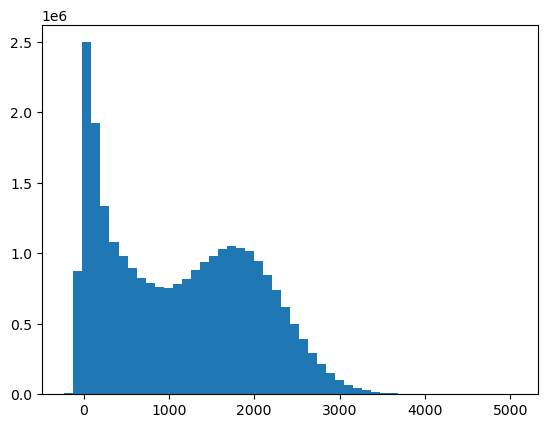

In [3]:
print(dataTest.shape)
values = np.array(dataTest)
print(np.min(values))
print(np.max(values))
plt.hist(values.ravel(),bins=50)

### Load the Network
Ensure that ```dataName``` is set same as in ```Convallaria-Training.ipynb```.

In [9]:
# Load the network, created in the 'Convallaria-Training.ipynb' notebook
dataName = 'convallaria' # Use the same name as used in training. This is a part of model name created in Convallaria-Training.ipynb 
nameModel = '_network_example'
path2='./data/Convallaria_diaphragm/'
#net = torch.load(path2 + "last_" + dataName + nameModel + ".net")
net = torch.load("./data/Convallaria_diaphragm/last_convallaria_network_example_sigma1.5.net")

### Evaluation

In [10]:
print(im.shape[0])
print(im.shape)
print(dataTest.shape[0])

512
(512, 512)
100


image: 0
PSNR input 22.88478165795968
PSNR denoised 33.10903143763645
-----------------------------------
image: 1
PSNR input 22.964698052700086
PSNR denoised 33.31674098841657
-----------------------------------
image: 2
PSNR input 22.985738916630964
PSNR denoised 33.349764338414175
-----------------------------------
image: 3
PSNR input 23.01624983397927
PSNR denoised 33.381938762396565
-----------------------------------
image: 4
PSNR input 22.99811531447237
PSNR denoised 33.34769806397646
-----------------------------------
image: 5
PSNR input 23.050537215525196
PSNR denoised 33.41885586015173
-----------------------------------
image: 6
PSNR input 23.013536642732152
PSNR denoised 33.31607083220963
-----------------------------------
image: 7
PSNR input 23.04105043147541
PSNR denoised 33.40599759144147
-----------------------------------
image: 8
PSNR input 23.028271449977623
PSNR denoised 33.38676167707555
-----------------------------------
image: 9
PSNR input 23.03686485606129
P

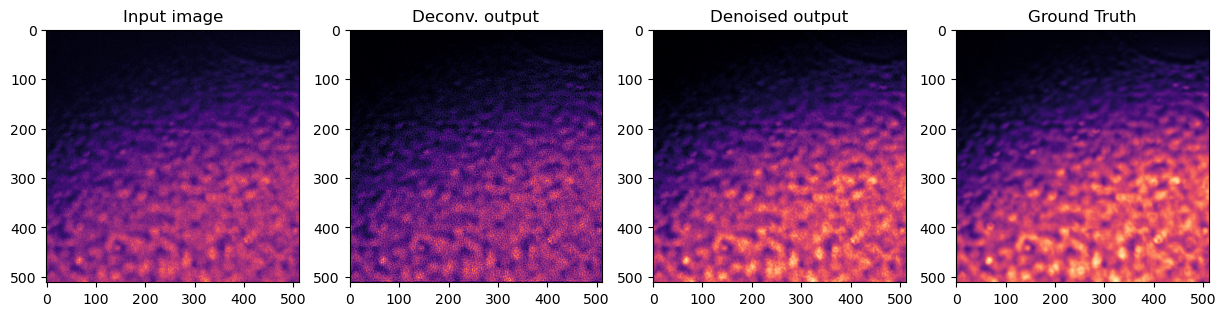

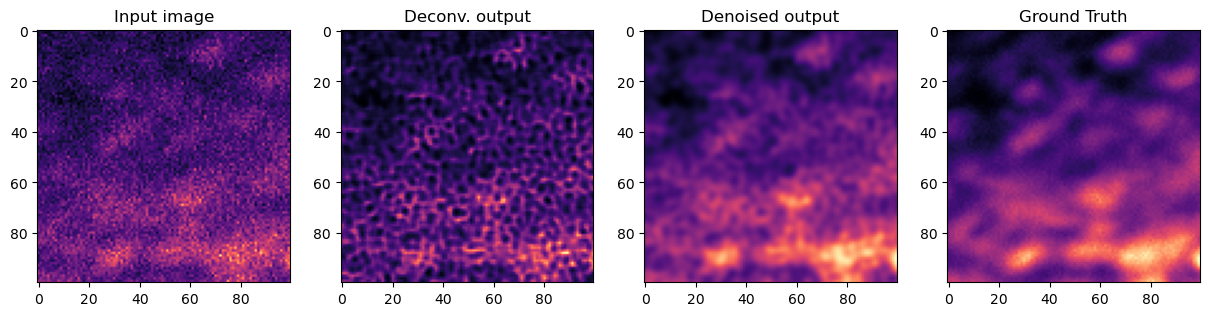

In [11]:
# Now we are processing data and calculating PSNR values.

psnr_result = []
psnr_input = []

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im = dataTest[index]
    gt = dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    # Here we are predicting the deconvolved and denoised image
    deconvolvedResult, denoisedResult = prediction.tiledPredict(im, net ,ps=256, overlap=48, device=device)
    
    # calculate PSNR
    rangePSNR = np.max(gt) - np.min(gt)
    psnr_result.append(PSNR(gt, denoisedResult, rangePSNR))
    psnr_input.append(PSNR(gt, im, rangePSNR)) 
    print ("image:", index)
    print ("PSNR input", PSNR(gt, im, rangePSNR))
    print ("PSNR denoised", PSNR(gt, denoisedResult, rangePSNR)) 
    print ('-----------------------------------')
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 4, 1)
plt.title('Input image')
plt.imshow(im, cmap="magma")

plt.subplot(1, 4, 2)
plt.title('Deconv. output')
plt.imshow(deconvolvedResult, cmap="magma")

plt.subplot(1, 4, 3)
plt.title('Denoised output')
plt.imshow(denoisedResult, cmap="magma")

plt.subplot(1, 4, 4)
plt.title('Ground Truth')
plt.imshow(gt, cmap="magma")

plt.figure(figsize=(15, 15))
plt.subplot(1, 4, 1)
plt.title('Input image')
plt.imshow(im[100:200,150:250], cmap="magma")

plt.subplot(1, 4, 2)
plt.title('Deconv. output')
plt.imshow(deconvolvedResult[100:200,150:250], cmap="magma")

plt.subplot(1, 4, 3)
plt.title('Denoised output')
plt.imshow(denoisedResult[100:200,150:250], cmap="magma")

plt.subplot(1, 4, 4)
plt.title('Ground Truth')
plt.imshow(gt[100:200,150:250], cmap="magma")

print("Avg PSNR input:", np.mean(np.array(psnr_input)),  '+-(2SEM)', 2*np.std(np.array(psnr_input))/np.sqrt(float(len(psnr_input))))
print("Avg PSNR denoised:", np.mean(np.array(psnr_result)),  '+-(2SEM)', 2*np.std(np.array(psnr_result))/np.sqrt(float(len(psnr_result))))